In [1]:
import re
import qiskit
import json
import time
import numpy as np

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.converters import circuit_to_dag

from fast_generator import fc_tree_commute_recur_lookahead_fast
from absorption import extract_CNOT_network, update_probabilities

from benchmarks.UCCSD_entanglers import generate_UCCSD_entanglers

from utilities import generate_pauli_strings
from circuit_generator import generate_opt_circuit, construct_qcc_circuit

In [2]:
#QAOA for MAXCUT 
# cost_hamiltonian = ['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII']
# mixer_hamiltonian = ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX']
# test_paulis = (cost_hamiltonian + mixer_hamiltonian)* 2
# test_params = [3.271] * 6 +  [2.874] * 5 + [2.641] * 6 + [0.9339]* 5


w1 = 0.13436424411240122
w2 = 0.8474337369372327
w3 = 0.763774618976614
L1_mix_parm = 0.7872782689900396*2
L1_cost_parm = 1.9380388913934923*-1
L2_mix_parm = -0.9174947695641181*2
L2_cost_parm = 0.002092886022676208*-1

# test_paulis = ['IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII','IZZ', 'ZIZ', 'ZZI','XII']
# test_params = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3 + [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] +[L2_mix_parm]

#these inputs are if we swap the 'X2' mixer for 'IIX','IXI','XII' for layer 2
# test_paulis = ['IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII','IZZ', 'ZIZ', 'ZZI','IIX','IXI','XII']
# test_params = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3 + [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] +[L2_mix_parm]*3


test_paulis = ['IZZ', 'ZIZ', 'ZZI','XII']
test_params = [w1*L1_cost_parm, w2*L1_cost_parm, w3*L1_cost_parm] + [L1_mix_parm]*3 + [w1*L2_cost_parm , w2*L2_cost_parm , w3*L2_cost_parm ] +[L2_mix_parm]*3



start_time = time.time()
opt_qc, append_clifford, sorted_entanglers = fc_tree_commute_recur_lookahead_fast(entanglers=test_paulis, params=test_params, barrier=False)
opt_qiskit = transpile(opt_qc, optimization_level=0, basis_gates=["cx", "sx", "x", "rz"])

# #need to add a layer of hadamard gates:
# for i in range(0, len(test_paulis[0])):
#     opt_qc.h(i)
opt_qc.measure_active()
end_time = time.time()
combined_time = end_time - start_time


origin_qc = construct_qcc_circuit(entanglers = test_paulis, params = test_params, barrier=False)
#generate the qiskit optimized circuit
origin_qiskit = transpile(origin_qc, optimization_level = 0, basis_gates = ["cx", "sx", "x", "rz"])
origin_qiskit.measure_active() 
origin_qiskit.count_ops()['cx']

6

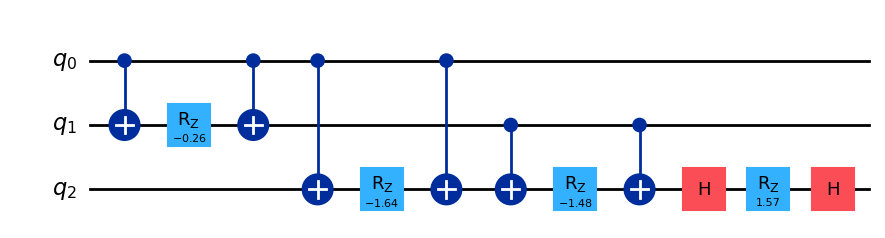

In [3]:
origin_qc.draw('mpl')

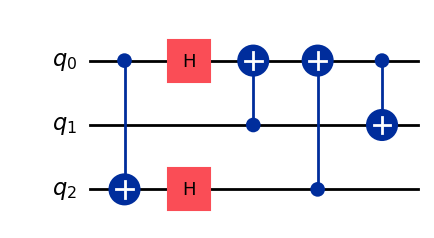

In [4]:
append_clifford.draw("mpl")

In [5]:
opt_qc.count_ops()

OrderedDict([('cx', 4), ('rz', 4), ('measure', 3), ('h', 2), ('barrier', 1)])

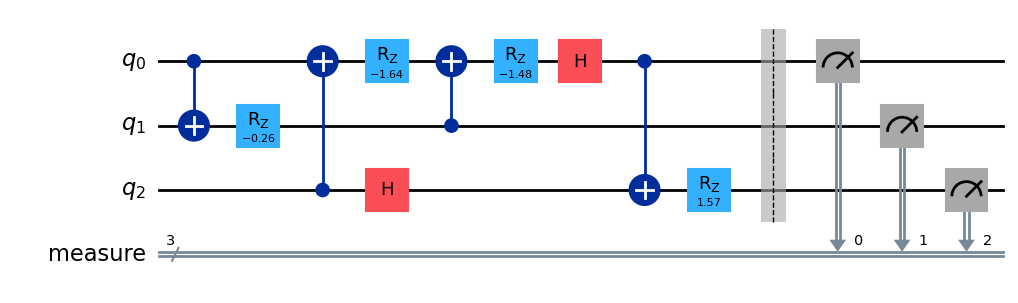

In [6]:
opt_qc.draw('mpl')

In [7]:
cnot_network = extract_CNOT_network(append_clifford)

In [8]:
#Run the original circuit on a noiseless simulator:
simulator = AerSimulator()
origin_result = simulator.run(origin_qiskit, shots = 10000).result()

In [9]:
def get_top_k_values(input_dict, k):
    # Sort the dictionary by values in descending order and return the top k items
    sorted_items = sorted(input_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_items[:k]

In [10]:
origin_probs= origin_result.get_counts()

In [11]:
top_k_states_origin = get_top_k_values(origin_probs, 20)
print(top_k_states_origin)

[('100', 5082), ('000', 4918)]


In [12]:
#Run the optimized circuit on a noiseless simulator:

opt_result = simulator.run(opt_qc, shots = 10000).result()

In [18]:
dag = circuit_to_dag(cnot_network)
updated_states = {}

updated_probs = update_probabilities(opt_result.get_counts(), dag)
print(opt_result.get_counts())

{'100': 2504, '001': 2567, '101': 2488, '000': 2441}


In [14]:
from qiskit.quantum_info.analysis import hellinger_fidelity

In [15]:
hellinger_fidelity(origin_probs, updated_probs)

0.4944983437454454

In [16]:
top_k_states_origin = get_top_k_values(origin_probs, 20)
print(top_k_states_origin)

[('100', 5082), ('000', 4918)]


In [17]:
top_k_states_updated = get_top_k_values(updated_probs, 20)
print(top_k_states_updated)

[('011', 2567), ('100', 2504), ('111', 2488), ('000', 2441)]
